## AI Programming with Python Nanodegree: Image Classifier Project
  - Do not make changes to the first 2 code cells, they are being used for setting up the `flowers` dataset and `cat_to_name.json`. Start writing code from third code cell onwards.
  - To use this notebook: `File > Save a copy in Drive`
  

In [ ]:
pip install torch
pip install torchvision
pip install collections
pip install PIL
pip install numpy 
pip install matplotlib
pip install json

In [ ]:
# Imports here
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json

In [4]:
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
class_counts = Counter(train_data.targets)  # Count occurrences of each class
num_classes = len(class_counts)
# Compute class weights (inverse of frequency)
class_weights = torch.tensor(
    [1.0 / class_counts[c] for c in range(num_classes)], dtype=torch.float32).to(device)
# Compute sample weights
sample_weights = [1.0 / class_counts[c] for c in train_data.targets]
# Create a sampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Use the sampler in the DataLoader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=sampler)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [7]:
# TODO: Build and train your network

# Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze the parameters of the pre-trained model to prevent them from being updated during training
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


In [8]:
# Define a new classifier to replace the last fully connected layer of the model
classifier = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 102),
    nn.LogSoftmax(dim=1)
)

# Replace the fully connected layer of the model with the new classifier
model.fc = classifier

# Define the loss function as Negative Log Likelihood Loss and class weights
criterion = nn.NLLLoss(weight=class_weights)

# Define the optimizer to update the parameters of the classifier
learnrate = 0.001
optimizer = optim.AdamW(model.fc.parameters(), lr=learnrate)

# Move the model to the specified device (GPU or CPU)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Set the number of epochs for training
epochs = 5
step = 0
running_loss = 0
print_every = 50 # Print training progress every 50 steps

In [10]:
# Training loop
for epoch in range(epochs):
    for images, labels in trainloader:
        step += 1

        # Move images and labels to the specified device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: compute the model output
        logps = model(images)

        # Calculate the loss using the predicted outputs and true labels
        loss = criterion(logps, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

        # Evaluate the model every 'print_every' steps
        if step % print_every == 0:
            model.eval()  # Set the model to evaluation mode
            valid_loss = 0
            accuracy = 0

            # Loop through the validation data
            for images, labels in validloader:
                # Move validation images and labels to the specified device
                images, labels = images.to(device), labels.to(device)

                # Forward pass: compute the model output for validation data
                logps = model(images)

                # Calculate the loss for validation data
                loss = criterion(logps, labels)
                valid_loss += loss.item()

                # Calculate probabilities from log probabilities
                ps = torch.exp(logps)

                # Get the top predicted class
                top_ps, top_class = ps.topk(1, dim=1)

                # Check if the predicted class matches the true labels
                equality = top_class == labels.view(*top_class.shape)

                # Calculate accuracy
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

            # Print training and Validation statistics
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")

            # Reset the running loss for the next print interval
            running_loss = 0

            # Set the model back to training mode
            model.train()

Epoch 1/5.. Train loss: 4.337.. Validation loss: 4.156.. Validation accuracy: 0.078
Epoch 1/5.. Train loss: 3.216.. Validation loss: 2.868.. Validation accuracy: 0.280
Epoch 2/5.. Train loss: 2.218.. Validation loss: 2.093.. Validation accuracy: 0.391
Epoch 2/5.. Train loss: 1.673.. Validation loss: 1.607.. Validation accuracy: 0.512
Epoch 3/5.. Train loss: 1.415.. Validation loss: 1.394.. Validation accuracy: 0.574
Epoch 3/5.. Train loss: 1.237.. Validation loss: 1.263.. Validation accuracy: 0.623
Epoch 4/5.. Train loss: 1.133.. Validation loss: 1.051.. Validation accuracy: 0.691
Epoch 4/5.. Train loss: 1.008.. Validation loss: 0.931.. Validation accuracy: 0.731
Epoch 5/5.. Train loss: 0.949.. Validation loss: 0.977.. Validation accuracy: 0.686
Epoch 5/5.. Train loss: 0.898.. Validation loss: 0.800.. Validation accuracy: 0.769


In [11]:
# TODO: Do validation on the test set

# Set the model to evaluation mode
model.eval()

# Initialize variables to track accuracy
correct = 0
total = 0

# Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to the specified device
        images, labels = images.to(device), labels.to(device)

        # Forward pass: get model predictions
        logps = model(images)

        # Convert log probabilities to probabilities
        ps = torch.exp(logps)

        # Get the top predicted class
        top_ps, top_class = ps.topk(1, dim=1)

        # Compare predictions to true labels
        correct += (top_class.squeeze() == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total samples

# Calculate accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 71.92%


In [12]:
# TODO: Save the checkpoint
# Attach class_to_idx to the model
model.class_to_idx = train_data.class_to_idx

# Define the checkpoint dictionary
checkpoint = {
    'model_state_dict': model.state_dict(),  # Model parameters
    'class_to_idx': model.class_to_idx,  # Class mapping
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
    'epochs': epochs  # Number of epochs trained
}

# Save the checkpoint
torch.save(checkpoint, 'checkpoint.pth')


In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    # Rebuild the model architecture
    model = models.resnet50(pretrained=True)

    # Replace the classifier with the one from the checkpoint
    classifier = nn.Sequential(
        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 102),
        nn.LogSoftmax(dim=1)
    )
    model.fc = classifier

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model

In [14]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # TODO: Process a PIL image for use in a PyTorch model
    # Open the image
    image = Image.open(image)

    image.resize((256, 256)) # Resize

    # Center Crop to 224x224
    width, height = image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    image = image.crop((left, top, right, bottom))

    # Convert to NumPy array & normalize
    np_image = np.array(image) / 255.0

    # Normalize using mean and standard deviation per channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions (H, W, C) → (C, H, W)
    np_image = np_image.transpose((2, 0, 1))

    tensor_image = torch.tensor(np_image, dtype=torch.float32)

    return tensor_image




In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # TODO: Implement the code to predict the class from an image file
    # Process the image
    image = process_image(image_path)

    # Convert to a PyTorch tensor and add batch dimension
    image = image.unsqueeze(0)  # Shape: (1, C, H, W)

    # Ensure model is in evaluation mode & move image to same device as model
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)

    # Forward pass (disable gradient computation for efficiency)
    with torch.no_grad():
        output = model(image)

    # Convert log probabilities to actual probabilities using softmax
    probabilities = torch.exp(output)

    # Get the top-K probabilities and their corresponding class indices
    top_probs, top_indices = probabilities.topk(topk, dim=1)

    # Convert tensors to lists
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()

    # Invert class_to_idx dictionary to map indices to actual class labels
    idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_indices]

    return top_probs, top_classes


In [4]:
# Load category-to-name mapping
with open("cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

image_path = "rose.jpeg"  # Replace with your image path

# Get predictions
probs, classes = predict(image_path, model, topk=5)

# Convert class indices to flower names (Ensure class keys are strings)
flower_names = [cat_to_name[str(class_)] for class_ in classes]

# Process the image
image = process_image(image_path)  # Ensure this returns a Torch tensor

# Display the image
fig, (ax1, ax2) = plt.subplots(figsize=(6, 10), nrows=2)

# Convert tensor to image format
image = image.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) → (H, W, C)

ax1.imshow(image)  # Show image
ax1.axis('off')  # Hide axes
ax1.set_title(flower_names[0])  # Set title as the most probable class

# Create horizontal bar chart for probabilities
ax2.barh(flower_names, probs, color="blue")
ax2.invert_yaxis()  # Ensure highest probability is at the top
ax2.set_xlabel("Probability")

plt.show()


NameError: name 'json' is not defined

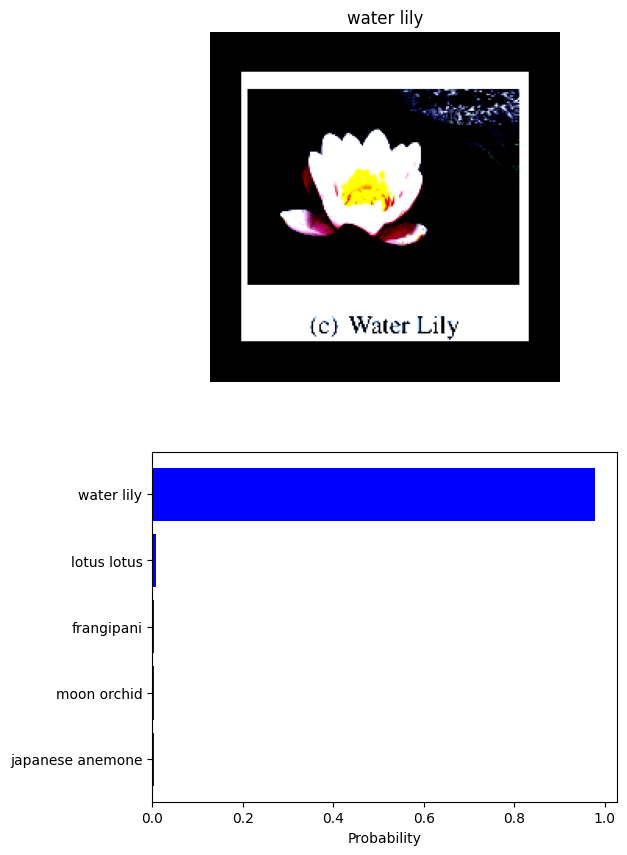

In [27]:
# Load category-to-name mapping
with open("cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

image_path = "waterlily.jpeg"  # Replace with your image path

# Get predictions
probs, classes = predict(image_path, model, topk=5)

# Convert class indices to flower names (Ensure class keys are strings)
flower_names = [cat_to_name[str(class_)] for class_ in classes]

# Process the image
image = process_image(image_path)  # Ensure this returns a Torch tensor

# Display the image
fig, (ax1, ax2) = plt.subplots(figsize=(6, 10), nrows=2)

# Convert tensor to image format
image = image.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) → (H, W, C)

ax1.imshow(image)  # Show image
ax1.axis('off')  # Hide axes
ax1.set_title(flower_names[0])  # Set title as the most probable class

# Create horizontal bar chart for probabilities
ax2.barh(flower_names, probs, color="blue")
ax2.invert_yaxis()  # Ensure highest probability is at the top
ax2.set_xlabel("Probability")

plt.show()


In [20]:
%%writefile train.py
import argparse
# Import necessary modules and functions
from functions import build_model, train_model, load_data, save_checkpoint
import torch

def main():
    parser = argparse.ArgumentParser(description="Train a neural network on flower data.")
    parser.add_argument("data_directory", type=str, help="Path to the dataset")
    parser.add_argument("--save_dir", type=str, default="saved_models", help="Directory to save checkpoints")
    parser.add_argument("--arch", type=str, default="resnet50", help="Model architecture")
    parser.add_argument("--learning_rate", type=float, default=0.001, help="Learning rate")
    parser.add_argument("--hidden_layer_1_units", type=int, default=256, help="Number of neurons/units in first hidden layer")
    parser.add_argument("--hidden_layer_2_units", type=int, default=128, help="Number of neurons/units in second hidden layer")
    parser.add_argument("--epochs", type=int, default=5, help="Number of epochs")
    parser.add_argument("--gpu", action="store_true", help="Use GPU for training")
    args = parser.parse_args()

    # Load the data
    trainloader, validloader, testloader = load_data(args.data_directory)
    # Determine device (use GPU if specified and available)
    device = torch.device("cuda" if args.gpu and torch.cuda.is_available() else "cpu")
    # Build the model
    model = build_model(args.arch, args.hidden_layer_1_units, args.hidden_layer_2_units)
    model.to(device)  # Move model to GPU/CPU
    # Train the model
    optimizer = train_model(model, trainloader, validloader, args.epochs, args.learning_rate, args.gpu)
    # Save the checkpoint
    save_checkpoint(model, optimizer, args.epochs, trainloader.dataset.class_to_idx)

if __name__ == '__main__':
    main()


Writing train.py


In [21]:
%%writefile predict.py
import argparse
# Import necessary modules and functions
from functions import load_checkpoint, process_image, predict

def main():
    parser = argparse.ArgumentParser(description="Predict flower name from an image using a trained network.")
    parser.add_argument("input", type=str, help="Path to the input image")
    parser.add_argument("checkpoint", type=str, help="Path to the model checkpoint")
    parser.add_argument("--top_k", type=int, default=1, help="Return top K most likely classes")
    parser.add_argument("--category_names", type=str, help="Path to JSON file mapping categories to real names")
    parser.add_argument("--gpu", action="store_true", help="Use GPU for inference")
    args = parser.parse_args()

    # Load the model from checkpoint
    model = load_checkpoint(args.checkpoint)

    # Process the image
    image = process_image(args.input)
    # Predict the class
    probs, classes = predict(args.input, model, args.top_k, args.gpu)

    # Optionally map categories to real names
    if args.category_names:
        import json
        with open(args.category_names, 'r') as f:
            cat_to_name = json.load(f)
        classes = [cat_to_name.get(str(cls), cls) for cls in classes]

    print("Predicted Classes:", classes)
    print("Probabilities:", probs)

if __name__ == '__main__':
    main()


Writing predict.py


In [22]:
%%writefile functions.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import optimizer
from torchvision import datasets, transforms, models
from collections import Counter
from PIL import Image
import numpy as np
import json

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data(data_dir):
  train_dir = data_dir + '/train'
  valid_dir = data_dir + '/valid'
  test_dir = data_dir + '/test'

  # Define your transforms for the training, validation, and testing sets
  train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
  valid_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
  test_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

  # Load the datasets with ImageFolder
  train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
  valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
  test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

  # Using the image datasets and the trainforms, define the dataloaders
  class_counts = Counter(train_data.targets)  # Count occurrences of each class
  num_classes = len(class_counts)
  # Compute class weights (inverse of frequency)
  class_weights = torch.tensor(
      [1.0 / class_counts[c] for c in range(num_classes)], dtype=torch.float32).to(device)
  # Compute sample weights
  sample_weights = [1.0 / class_counts[c] for c in train_data.targets]
  # Create a sampler
  sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

  # Use the sampler in the DataLoader
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=sampler)
  validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
  testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

  return trainloader, validloader, testloader

def build_model(architecture, hidden_layer_1_units, hidden_layer_2_units):
  # Build your network
  # Load a pre-trained ResNet50 model
  model = models.resnet50(pretrained=True)

  # Freeze the parameters of the pre-trained model to prevent them from being updated during training
  for param in model.parameters():
      param.requires_grad = False

  # Define a new classifier to replace the last fully connected layer of the model
  classifier = nn.Sequential(
    nn.Linear(2048, hidden_layer_1_units),
    nn.ReLU(),
    nn.Linear(hidden_layer_1_units, hidden_layer_2_units),
    nn.ReLU(),
    nn.Linear(hidden_layer_2_units, 102),
    nn.LogSoftmax(dim=1)
  )

  # Replace the fully connected layer of the model with the new classifier
  model.fc = classifier

  return model


def train_model(model, trainloader, validloader, epochs, learning_rate, gpu):
  # Set the number of epochs for training
  step = 0
  running_loss = 0
  print_every = 50
  criterion = nn.NLLLoss()
  optimizer = optim.AdamW(model.fc.parameters(), lr=learning_rate)

  # Move the model to the specified device (GPU or CPU)
  model.to(device)# Print training progress every 50 steps
  # Training loop
  for epoch in range(epochs):
      for images, labels in trainloader:
          step += 1

          # Move images and labels to the specified device
          images, labels = images.to(device), labels.to(device)

          # Zero the gradients for the optimizer
          optimizer.zero_grad()

          # Forward pass: compute the model output
          logps = model(images)

          # Calculate the loss using the predicted outputs and true labels
          loss = criterion(logps, labels)

          # Backward pass: compute gradients
          loss.backward()

          # Update the model parameters
          optimizer.step()

          # Accumulate the running loss
          running_loss += loss.item()

          # Evaluate the model every 'print_every' steps
          if step % print_every == 0:
              model.eval()  # Set the model to evaluation mode
              valid_loss = 0
              accuracy = 0

              # Loop through the validation data
              for images, labels in validloader:
                  # Move validation images and labels to the specified device
                  images, labels = images.to(device), labels.to(device)

                  # Forward pass: compute the model output for validation data
                  logps = model(images)

                  # Calculate the loss for validation data
                  loss = criterion(logps, labels)
                  valid_loss += loss.item()

                  # Calculate probabilities from log probabilities
                  ps = torch.exp(logps)

                  # Get the top predicted class
                  top_ps, top_class = ps.topk(1, dim=1)

                  # Check if the predicted class matches the true labels
                  equality = top_class == labels.view(*top_class.shape)

                  # Calculate accuracy
                  accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

              # Print training and Validation statistics
              print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                    f"Validation accuracy: {accuracy/len(validloader):.3f}")

              # Reset the running loss for the next print interval
              running_loss = 0

              # Set the model back to training mode
              model.train()
  return optimizer
# Save the checkpoint
# Attach class_to_idx to the model
def save_checkpoint(model, optimizer, epochs, class_to_idx):
    # Define the checkpoint dictionary
    checkpoint = {
      'model_state_dict': model.state_dict(),  # Model parameters
      'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
      'epochs': epochs,  # Number of epochs trained
      'class_to_idx': class_to_idx  # Save class mapping
      }

    # Save the checkpoint
    torch.save(checkpoint, 'checkpoint.pth')

# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    # Rebuild the model architecture
    model = models.resnet50(pretrained=True)

    # Replace the classifier with the one from the checkpoint
    classifier = nn.Sequential(
        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 102),
        nn.LogSoftmax(dim=1)
    )
    model.fc = classifier

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # Load optimizer state
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Process a PIL image for use in a PyTorch model
    # Open the image
    image = Image.open(image)

    image.resize((256, 256)) # Resize

    # Center Crop to 224x224
    width, height = image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    image = image.crop((left, top, right, bottom))

    # Convert to NumPy array & normalize
    np_image = np.array(image) / 255.0

    # Normalize using mean and standard deviation per channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions (H, W, C) → (C, H, W)
    np_image = np_image.transpose((2, 0, 1))

    tensor_image = torch.tensor(np_image, dtype=torch.float32)

    return tensor_image

def predict(image_path, model, topk, gpu):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Implement the code to predict the class from an image file
    # Process the image
    image = process_image(image_path)

    # Convert to a PyTorch tensor and add batch dimension
    image = image.unsqueeze(0)  # Shape: (1, C, H, W)

    # Ensure model is in evaluation mode & move image to same device as model
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)

    # Forward pass (disable gradient computation for efficiency)
    with torch.no_grad():
        output = model(image)

    # Convert log probabilities to actual probabilities using softmax
    probabilities = torch.exp(output)

    # Get the top-K probabilities and their corresponding class indices
    top_probs, top_indices = probabilities.topk(topk, dim=1)

    # Convert tensors to lists
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()

    # Invert class_to_idx dictionary to map indices to actual class labels
    idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_indices]

    return top_probs, top_classes


Writing functions.py


In [23]:
!python train.py flowers --save_dir saved_models --arch "resnet50" --learning_rate 0.001 --hidden_layer_1_units 256 --hidden_layer_2_units 128 --epochs 5 --gpu

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5.. Train loss: 4.388.. Validation loss: 3.852.. Validation accuracy: 0.144
Epoch 1/5.. Train loss: 3.225.. Validation loss: 2.364.. Validation accuracy: 0.438
Epoch 2/5.. Train loss: 2.117.. Validation loss: 1.528.. Validation accuracy: 0.599
Epoch 2/5.. Train loss: 1.631.. Validation loss: 1.285.. Validation accuracy: 0.630
Epoch 3/5.. Train loss: 1.348.. Validatio

In [32]:
!python predict.py lotus.jpeg checkpoint.pth --top_k 3 --category_names cat_to_name.json --gpu

/content/functions.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.

In [2]:
!python predict.py waterlily.jpeg checkpoint.pth --top_k 3 --category_names cat_to_name.json --gpu

Predicted Classes: ['water lily', 'lotus lotus', 'frangipani']
Probabilities: [0.9556091  0.02045408 0.01706157]


C:\Users\Fareedah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Fareedah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
!python predict.py sunflower.jpg checkpoint.pth --top_k 3 --category_names cat_to_name.json --gpu

Predicted Classes: ['californian poppy', 'buttercup', 'sunflower']
Probabilities: [0.19125363 0.1412222  0.12423483]


C:\Users\Fareedah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Fareedah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


: 